# Energy-usage optimization for a Microgrid with a Battery
***
In this Jupyter Notebook, we will construct a linear programming model (LP) using Pyomo and the GLPK solver for optimizing the flow and storage of energy in a microgrid that has both renewable and non-renewable energy sources and a battery. 
The Jupyter Notebook contains the following sections:
1. Imports
2. Data Definitions
3. Data Analysis and Visualization
4. Model Parameters
5. Model Decision Variables
6. Objective Function
7. Model Constraints
8. Model Output and Results

<figure>
<img src="Microgrid Optimization Model.jpg" style="height:250px,width:100px,align:center">
<figcaption>Figure 1: Visual representation of Model</figcaption>
</figure>


### Model Assumptions:
1. The battery holds its charge from 1 state to the next, i.e. it does not deplete idly.
2. There are 2 source nodes, one supplying renewable energy and the other supplying energy at market price.
3. The formula for charging efficiency is $actual\_charge\_rate = 0.95*charge\_rate$.
4. The formula for discharging efficiency is $actual\_discharge\_rate = discharge\_rate/0.95$.
5. Renewable Energy is free, i.e there is no cost associated with utilizing renewable energy.
6. In order to maximize revenue, the grid can supply more than the demand required.
7. The max charging and discharging rate = 250kwh is considered before the efficiency losses.

In [155]:
# Imports
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [76]:
# Data Definitions
time_periods = [t for t in range(0,12)]
max_capacity = 1000
charging_efficiency = 0.95
discharging_efficiency = 0.95
min_charge_state = 100
max_charge_state = 950
max_charge_discharge_rate = 250

price_dict = {0:0.05,1:0.04,2:0.04,3:0.03,4:0.03,5:0.04,6:0.06,7:0.08,8:0.10,9:0.12,10:0.14,11:0.15}
demand_dict = {0:300,1:280,2:260,3:250,4:240,5:260,6:300,7:350,8:400,9:450,10:500,11:550}

solar_gen_dict = {0:0,1:0,2:0,3:0,4:0,5:50,6:150,7:300,8:400,9:450,10:480,11:500}
wind_gen_dict = {0:100,1:80,2:50,3:30,4:20,5:40,6:50,7:80,8:120,9:150,10:180,11:200}

***
## 1. Data Analysis and Visualization

In this section we will go through the total demand requirements and the total renewable energy supplied across all time intervals. We will also analyze how the price fluctuates across time.


In [125]:
# Conclusion: The total Demand across all time periods is greater than the Total Energy supplied from the Renewable energy sources
# and the initial battery charge.
total_energy = sum(solar_gen_dict[t] + wind_gen_dict[t] for t in time_periods) + 400
total_demand = sum(demand_dict[t] for t in time_periods)
print('Total Energy:', total_energy)
print('Total Demand:', total_demand)

Total Energy: 3830
Total Demand: 4140


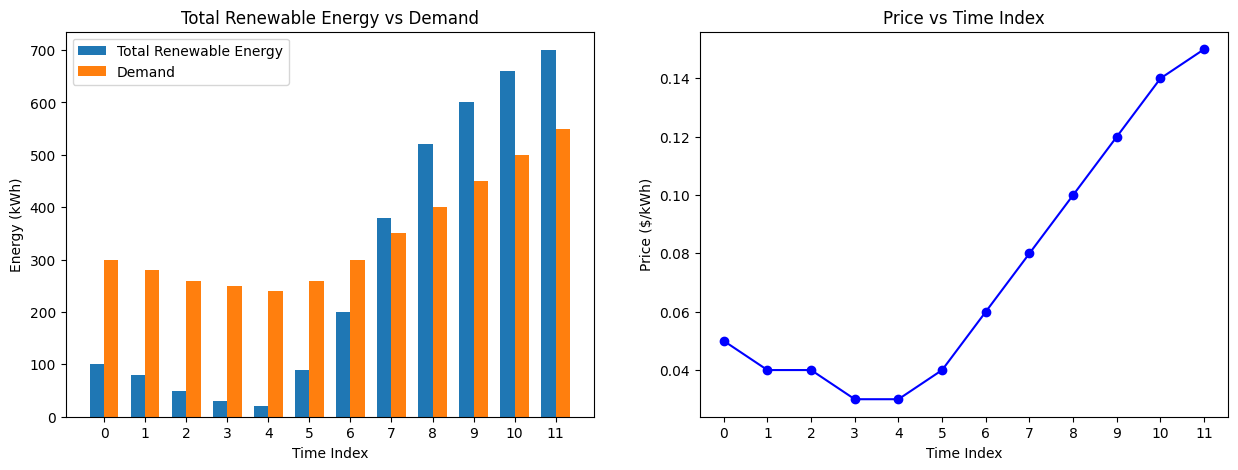

In [134]:
# Summing up total renewable energy resources
total_renewable = {key: solar_gen_dict[key] + wind_gen_dict[key] for key in solar_gen_dict}

# Extracting values for plotting
time_indices = np.arange(len(price_dict))
total_renewable_values = [total_renewable[key] for key in time_indices]
demand_values = [demand_dict[key] for key in time_indices]
price_values = [price_dict[key] for key in time_indices]

# Plotting side-by-side bar plot for renewable resources and demand
width = 0.35  # Width of the bars

fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].bar(time_indices - width/2, total_renewable_values, width, label='Total Renewable Energy')
ax[0].bar(time_indices + width/2, demand_values, width, label='Demand')

ax[0].set_xlabel('Time Index')
ax[0].set_ylabel('Energy (kWh)')
ax[0].set_title('Figure 2: Total Renewable Energy vs Demand')
ax[0].set_xticks(time_indices)
ax[0].legend()

# # Plotting line chart for price against time indices
ax[1].plot(time_indices, price_values, marker='o', linestyle='-', color='b')

ax[1].set_xlabel('Time Index')
ax[1].set_ylabel('Price ($/kWh)')
ax[1].set_title('Figure 3: Price vs Time Index')
ax[1].set_xticks(time_indices)

plt.show()

### 1.1 Conclusion from Data Analysis:
- The total demand = **4140kwh** across all time periods is greater than the sum of the initial battery charge(500 kwh) and total energy supplied from the renewable energy sources = **3830 kwh**.
- **Figure 2**: The clustered bar chart of **Energy vs Time** shows that at the earlier time periods, available renewable energy is lesser thus more energy must be purchased, while later on renewable energy can be utilized
- **Figure 3**: The line chart of **Price vs Time** shows that the prices are **lowest** between the **0-5** time indices, hence energy should be purchased at these points and sold at the higher price indices **6-11** for **higher revenue**

***
## 4. Model Parameters
The parameters from the given data used in the model are as follows:
- **T**: Set of time indices from 0 to 11

- **Max_Cap**: Max capacity; The maximum capacity of the battery $= 1000 kwh$
- **Charge_Eff**: Charge efficiency; The charging efficiency of the battery $= 0.95$
- **Discharge_Eff**: Discharge efficiency; The discharging efficiency of the battery $= 0.95$
- **Min_C_State**: Minimum charge state; The minimum charge the battery can hold $= 100kwh$
- **Max_C_State**: Maximum charge state; The maximum charge the battery can hold $= 950kwh$
- **Max_Charge_Discharge_Rate**: Maximum charging and discharging rate; The maximum energy the battery can lose or gain at a given time index $= 250kwh$
- **Price**: The price matrix of the energy bought or sold at each time index given from data
- **Demand**: The customer demand at each time index given from data
- **Solar_Gen**: Solar energy generation; The solar energy generated at each time index
- **Wind_Gen**: Wind energy generation; The wind energy generated at each time index
- **Initial_Charge**: The initial charge of the battery $= 500kwh$

In [112]:
# Initialize the model
model = pyo.ConcreteModel()
   
# Initialize Sets and Parameters 
model.T = pyo.Set(initialize = time_periods)
model.Max_Cap = pyo.Param(initialize = max_capacity)
model.Charge_Eff = pyo.Param(initialize = charging_efficiency)
model.Discharge_Eff = pyo.Param(initialize = discharging_efficiency)
model.Min_C_State = pyo.Param(initialize = min_charge_state)
model.Max_C_State = pyo.Param(initialize = max_charge_state)
model.Max_Charge_Discharge_Rate = pyo.Param(initialize = max_charge_discharge_rate)
model.Price = pyo.Param(model.T,initialize = price_dict)
model.Demand = pyo.Param(model.T,initialize = demand_dict)
model.Solar_Gen = pyo.Param(model.T,initialize = solar_gen_dict)
model.Wind_Gen = pyo.Param(model.T,initialize = wind_gen_dict)
model.Initial_Charge = pyo.Param(initialize = 500)


***
## 5. Model Decision Variables
The decision variables used in the model are as follows:
- **B_State**: Battery State; Represents the energy(kwh) stored by the battery at time index T; *Indexed Component*; *Domain: NonNegativeReal*

- **Charge_R**: Charge Rate; Represents the energy(kwh) passed to the battery for charging at time index T; *Indexed Component*; *Domain: NonNegativeReal*
- **Discharge_R**: Discharge Rate; Represents the energy(kwh) passed to the battery for discharging at time index T; *Indexed Component*; *Domain: NonNegativeReal*
- **Grid_I**: Grid Import; Represents the energy(kwh) taken from all the sources and passed to the battery and grid output at time index T; *Indexed Component*; *Domain: NonNegativeReal*
- **Grid_E**: Grid Export; Represents the energy(kwh) passed to the customers to satisfy demand at time index T; *Indexed Component*; *Domain: NonNegativeReal*
- **Relative_Flow**: Relative Flow; Represents the import energy(kwh) that is not passed to the battery and instead sent to grid output; *Indexed Component*; *Domain: NonNegativeReal*
- **Charge_Binary**: Charge Binary; Binary variable for restricting charging and discharging of the battery at the one time index T; *Indexed Component*; *Domain: Binary*
- **Energy_Bought**: Energy Bought; Represents the non-renewable energy(kwh) purchased at each time index T; *Indexed Component*; *Domain: NonNegativeReal* 


In [113]:
# Variables
model.B_State = pyo.Var(model.T, bounds = (0,model.Max_Cap)) # initialize = initBattery
model.Charge_R = pyo.Var(model.T, bounds = (0,model.Max_Charge_Discharge_Rate))
model.Discharge_R = pyo.Var(model.T, bounds = (0,model.Max_Charge_Discharge_Rate))
model.Grid_I = pyo.Var(model.T, within = pyo.NonNegativeReals)
model.Grid_E = pyo.Var(model.T, within = pyo.NonNegativeReals)
model.Relative_Flow = pyo.Var(model.T, within = pyo.NonNegativeReals)   # Can be eliminated if import and export constraiints combined
model.Charge_Binary = pyo.Var(model.T, within = pyo.Binary)
model.Energy_Bought = pyo.Var(model.T, within = pyo.NonNegativeReals)

***
## 6. Objective Function

Since we want to minimize the total cost of purchasing energy, while maximizing the revenue of the energy sold after meeting customers' demands, we will sum the difference of the product of the cost matrix with the energy purchased(time t) and the grid export energy(time t) over all time indices.

$\text{Minimize} \quad \sum_{t \in T} \text{Price}_t \times \left(\text{Energy\_Bought}_t - \text{Grid\_E}_t\right)
$

In [114]:
# Objective Function
def obj_rule(model):
    return sum(model.Price[t]*(model.Energy_Bought[t] - model.Grid_E[t]) for t in model.T)
model.obj = pyo.Objective(rule = obj_rule, sense = pyo.minimize)

***
## 7. Model Constraints

The constraints used in the model are as follows:
- **BatteryConstraint**: The current charge in the battery is equal to the previous state + the charging rate - discharging rate; T constraints

- **stateMinCharge**: The battery state must not fall below 100 kwh; T constraints
- **stateMaxCharge**: The battery state must not exceed 950 kwh; T constraints
- **gridImportConstraint**:  The energy sent out to the battery + the energy flow directly sent to grid export equals the grid import energy equals; T constraints
- **gridExportConstraint**: The grid export energy sent to customers equals the battery discharge energy + the energy flow coming from the grid import; T constraints
- **sourceEnergyConstraint**: The grid import energy should be less than or equal to the energy coming from the renewable and non-renewable sources; T constraints
- **customerDemandConstraint**: The grid export energy must be greater than or equal to the customer demands; T constraints
- **chargeBinaryConstraint**: $0<= charge\_rate/250<= 1$, if $charge\_rate > 0$ then $charge\_binary == 1$ and thus $discharge\_rate == 0$; T constraints
- **dischargeBinaryConstraint**: $0<= discharge\_rate/250<= 1$, if $discharge\_rate > 0$ then $charge\_binary == 1$ and thus $charge\_rate == 0$; T constraints

In [115]:
# 1st Constraint: Battery State
def batteryConstraint(model, t):
    if t != 0:
        return model.B_State[t] == model.B_State[t-1] + model.Charge_Eff*model.Charge_R[t] - model.Discharge_R[t]/model.Discharge_Eff
    else:
        return model.B_State[t] == model.Initial_Charge + model.Charge_Eff*model.Charge_R[t] - model.Discharge_R[t]/model.Discharge_Eff
model.state_constr = pyo.Constraint(model.T, rule = batteryConstraint)

In [116]:
# 2nd Constraint: Min Battery Charge
def stateMinCharge(model,t):
    return model.B_State[t] >= model.Min_C_State
model.state_min_c_constr = pyo.Constraint(model.T, rule = stateMinCharge)    

In [117]:
# 3rd Constraint: Max Battery Charge
def stateMaxCharge(model,t):
    return model.B_State[t] <= model.Max_C_State
model.state_max_c_constr = pyo.Constraint(model.T, rule = stateMaxCharge)

In [118]:
# 4nd Constraint : Grid Import
def gridImportConstraint(model, t):
    return model.Grid_I[t] == model.Charge_Eff*model.Charge_R[t] + model.Relative_Flow[t]
model.grid_import_constr = pyo.Constraint(model.T, rule = gridImportConstraint)

In [119]:
# 5th Constraint : Grid Export
def gridExportConstraint(model, t):
    return model.Grid_E[t] == model.Discharge_R[t]/model.Discharge_Eff + model.Relative_Flow[t]
model.grid_export_constr = pyo.Constraint(model.T, rule = gridExportConstraint)

In [120]:
# 6th Constraint: Source Energy
def sourceEnergyConstraint(model, t):
    return model.Grid_I[t] <=  model.Solar_Gen[t] + model.Wind_Gen[t] + model.Energy_Bought[t]
model.source_energy_constr = pyo.Constraint(model.T, rule = sourceEnergyConstraint)

In [121]:
# 7th Constraint: Customer Demand
def customerDemandConstraint(model, t):
    return model.Grid_E[t] >= model.Demand[t]
model.customer_demand_constr = pyo.Constraint(model.T, rule = customerDemandConstraint)

In [122]:
# 8.1th Constraint: Disable simultaneous charge and discharge
def chargeBinaryConstraint(model,t):
    return model.Charge_R[t]/model.Max_Charge_Discharge_Rate <= model.Charge_Binary[t]
model.charge_binary_constr = pyo.Constraint(model.T, rule = chargeBinaryConstraint)

#8.2nd Constraint: Disable simultaneous charge and discharge
def dischargeBinaryConstraint(model,t):
    return model.Discharge_R[t]/model.Max_Charge_Discharge_Rate <= 1 - model.Charge_Binary[t]
model.discharge_binary_constr = pyo.Constraint(model.T, rule = dischargeBinaryConstraint)

***
## 8. Model Results

For solving the model, we will use the GLPK solver: https://www.gnu.org/software/glpk/.<BR>
We will assert the model to find an optimal solution. <br>
The model output for each variable is stored in a dataframe **output_df**.

In [123]:
solver = pyo.SolverFactory('glpk')
solver.options['log'] = 'grid.log'
results = solver.solve(model, tee=True, keepfiles = True )
pyo.assert_optimal_termination(results)
model.display()

Solver log file: '/var/folders/sw/987fj3xn4_sbrkjd_px3yrcm0000gn/T/tmp60wi80kb.glpk.log'
Solver solution file: '/var/folders/sw/987fj3xn4_sbrkjd_px3yrcm0000gn/T/tmpw2digflg.glpk.raw'
Solver problem files: ('/var/folders/sw/987fj3xn4_sbrkjd_px3yrcm0000gn/T/tmpperaogcs.pyomo.lp',)
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --log grid.log --write /var/folders/sw/987fj3xn4_sbrkjd_px3yrcm0000gn/T/tmpw2digflg.glpk.raw
 --wglp /var/folders/sw/987fj3xn4_sbrkjd_px3yrcm0000gn/T/tmpnitgfiu1.glpk.glp
 --cpxlp /var/folders/sw/987fj3xn4_sbrkjd_px3yrcm0000gn/T/tmpperaogcs.pyomo.lp
Reading problem data from '/var/folders/sw/987fj3xn4_sbrkjd_px3yrcm0000gn/T/tmpperaogcs.pyomo.lp'...
/var/folders/sw/987fj3xn4_sbrkjd_px3yrcm0000gn/T/tmpperaogcs.pyomo.lp:681: warning: lower bound of variable 'x171' redefined
/var/folders/sw/987fj3xn4_sbrkjd_px3yrcm0000gn/T/tmpperaogcs.pyomo.lp:681: warning: upper bound of variable 'x171' redefined
108 rows, 96 columns, 227 non-zeros
12 inte

In [169]:
# Generating the output Dataframe
output_df = pd.DataFrame()
for v in model.component_objects(pyo.Var,active=True):
    for index in v:
        output_df.at[index, v.name] = pyo.value(v[index])

Optimal Cost: -482.43 Dollars


In [143]:
output_df

,B_State,Charge_R,Discharge_R,Grid_I,Grid_E,Relative_Flow,Charge_Binary,Energy_Bought
0,236.842105,0.000000,2.500000e+02,100.000000,363.157895,100.000000,0.0,0.000000
1,100.000000,0.000000,1.300000e+02,143.157895,280.000000,143.157895,0.0,63.157895
2,337.500000,250.000000,0.000000e+00,497.500000,260.000000,260.000000,1.0,447.500000
3,575.000000,250.000000,0.000000e+00,487.500000,250.000000,250.000000,1.0,457.500000
4,812.500000,250.000000,0.000000e+00,477.500000,240.000000,240.000000,1.0,457.500000
5,950.000000,144.736842,2.633315e-14,397.500000,260.000000,260.000000,1.0,307.500000
6,950.000000,0.000000,0.000000e+00,300.000000,300.000000,300.000000,0.0,100.000000
7,950.000000,0.000000,0.000000e+00,380.000000,380.000000,380.000000,0.0,0.000000
8,889.473684,0.000000,5.750000e+01,520.000000,580.526316,520.000000,0.0,0.000000
9,626.315789,0.000000,2.500000e+02,600.000000,863.157895,600.000000,0.0,0.000000


In [172]:
#Printing the optimal cost
print(f'Optimal Cost: {pyo.value(model.obj):0.02f}$')

Optimal Cost: -482.43$


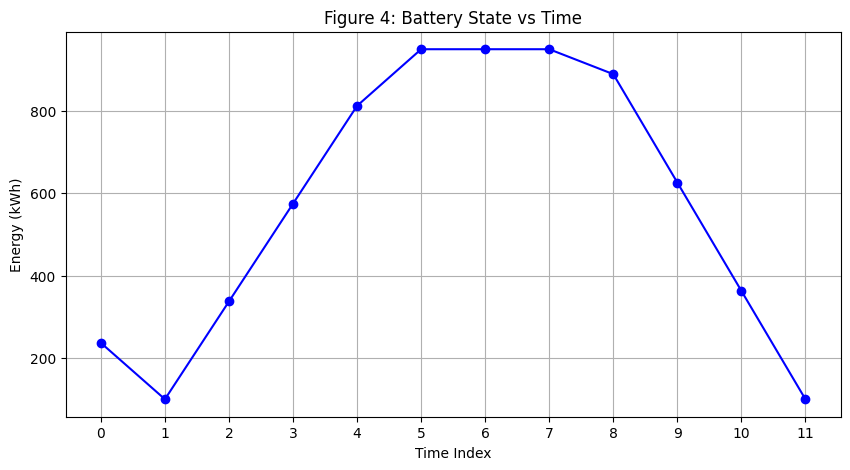

In [205]:
#Plotting the Battery State vs Time
plt.figure(figsize=(10, 5))
plt.plot(time_indices, output_df['B_State'], marker='o', linestyle='-', color='b')
plt.xlabel('Time Index')
plt.ylabel('Energy (kWh)')
plt.title('Figure 4: Battery State vs Time')
plt.xticks(time_indices)
plt.grid(True)
plt.show()

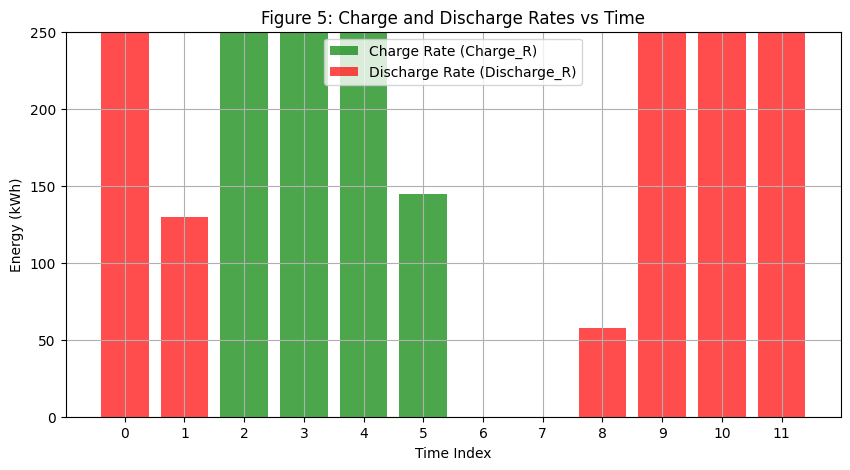

In [206]:
# Plotting the Charge and Discharge Rate schedule
plt.figure(figsize=(10, 5))
plt.bar(time_indices, output_df['Charge_R'], label='Charge Rate (Charge_R)', alpha=0.7, color='green')
plt.bar(time_indices, output_df['Discharge_R'], label='Discharge Rate (Discharge_R)', alpha=0.7, color='red', bottom=output_df['Charge_R'])
plt.xlabel('Time Index')
plt.ylabel('Energy (kWh)')
plt.title('Figure 5: Charge and Discharge Rates vs Time')
plt.xticks(time_indices)
plt.legend(loc='best')
plt.grid(True)
plt.show()

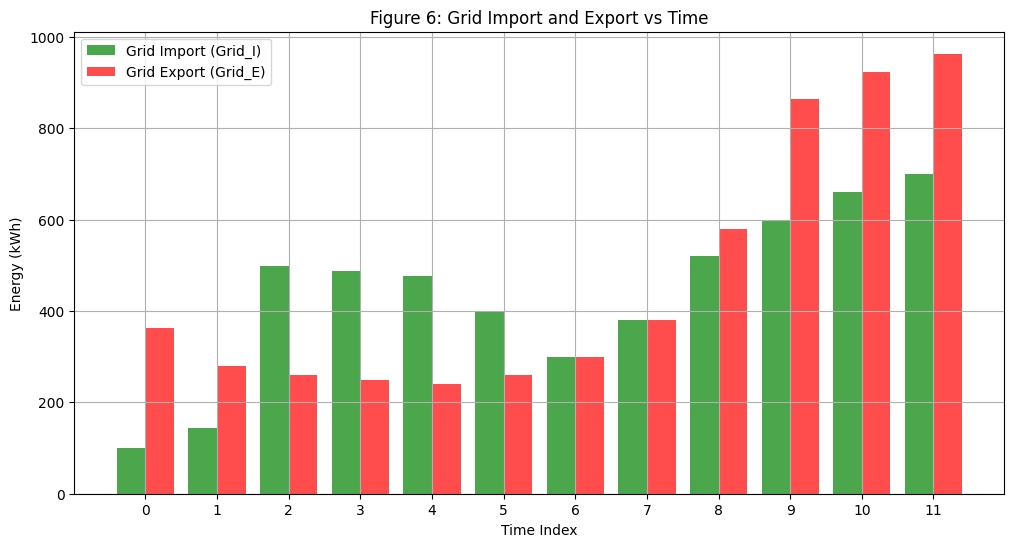

In [207]:
#Grid import and export schedule
plt.figure(figsize=(12, 6))
plt.bar(time_indices - 0.20, output_df['Grid_I'],width = 0.40 , label='Grid Import (Grid_I)', alpha=0.7, color='green')
plt.bar(time_indices + 0.20, output_df['Grid_E'],width = 0.40, label='Grid Export (Grid_E)', alpha=0.7, color='red')
plt.xlabel('Time Index')
plt.ylabel('Energy (kWh)')
plt.title('Figure 6: Grid Import and Export vs Time')
plt.xticks(time_indices)
plt.legend(loc='best')
plt.grid(True)
plt.show()

### 8.1 Conclusion and Interpretation

- The optimal cost of the entire operation is **-482.43$**, this means the grid achieved a **net revenue of 482.43$**

- **Figure 4 Battery State vs Time**: The battery state graph shows that the battery initially discharges to it's lowest point (100kwh) at state 1, then proceeds to charge upto its maximum state (950kwh) until state 5. It then holds this charge until state 7, while purchasing energy at market price to satisfy demands. After state 7, it discharges upto its lowest point(100kwh) eventually until state 11.
- **Figure 5 Charge and Discharge Rates vs Time**: The figure shows that at any point in time, the battery is either charging or discharging, but not both. Consistent with figure 3, the battery first discharges, then charges fully, holds that charge, and then discharges at the last time index
- **Figure 6 Grid Import and Export vs Time**: The figure shows that whenever the grid export exeeds the grid import, the battery supplies the energy difference. This is found in time indices: **(0,1,8,9,10,11)**. Other times, when the grid import exceeds the grid export, the battery is being charged. This is found in time inidces: **(2,3,4,5)**. In time indices **(6,7)**, grid import equals the grid export, so the battery state remains constant

##